<a href="https://colab.research.google.com/github/jhj030722/til/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9Dweek1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow

In [2]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) =\
keras.datasets. fashion_mnist. load_data()

In [3]:
print(train_input.shape, train_target.shape)
# train 데이터 크기 확인

(60000, 28, 28) (60000,)


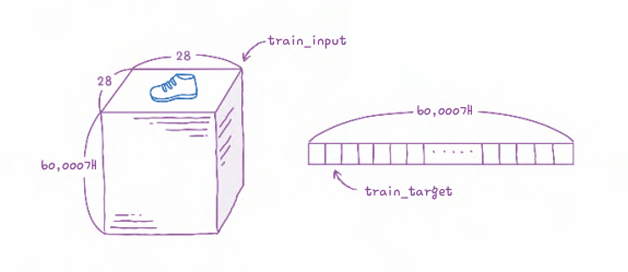

In [4]:
# test 데이터 크기
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


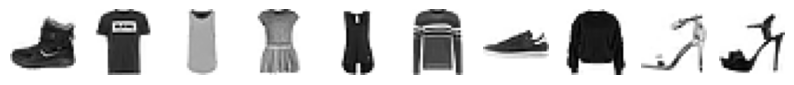

In [5]:
# 어떤 이미지인가요

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
  axs[i].imshow(train_input[i], cmap='gray_r')
  axs[i].axis('off')

plt.show()

In [6]:
# 처음 10개 샘플의 타깃값을 리스트로 만든 후 출력
print([int(train_target[i]) for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


패션 mnist의 타깃은 0~9까지의 숫자 레이블로 구성됨

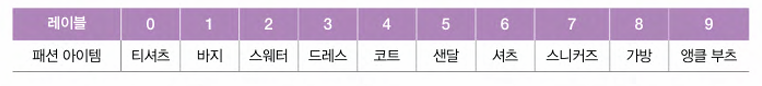

In [7]:
# 레이블 당 샘플 개수
import numpy as np
print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


0~9까지 레이블마다 6000개의 샘플 들어있음

# 로지스틱 회귀로 패션 아이템 분류하기

- 샘플이 60,000개나 되기 때문에, 전체 데이터 한꺼번에 훈련하는 것보다, 샘플을 하나씩 꺼내서 모델을 훈련하는게 더 효과적!
- 따라서 `확률적 경사하강법` 사용

- 4장) SGDClassifier 클래스의 loss 매개변수 log로 지정하여 로지스틱 손실 함수 최소화하는 확률적 경사 하강법
- 특성마다 값의 범위가 많이 다르다면 올바르게 손실함수 경사를 내려올 수 없음 => 표준화 필요
  - mnist의 경우 0-255 사이의 정숫값이므로 255로 나누어 0~1 사이의 값으로 정규화
  - 양수 값으로 이루어진 이미지 전처리할 때 널리 사용

2차원 배열인 각 샘플을 1차원 배열로 펼치기 (reshape 메서드)

In [8]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

# 샘플 개수(첫번째 차원)은 변하지 않고 원본 데이터의 두번째, 세번째 차원이 1차원으로 합쳐짐

In [9]:
print(train_scaled.shape)

(60000, 784)


In [10]:
# 교차 검증으로 성능 확인
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)  #SGDClassifer의 max_iter(반복 횟수) 5번으로 지정
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

0.8194166666666666


loss='log'는 최신 scikit-learn 버전에서는 **'log_loss'**로 바뀜

max_iters를 바꿔도 성능 크게 향상 x

1. 먼저, 로지스틱 회귀 식이 나옵니다:

`z = a×Weight + b×Length + c×Diagonal + d×Height + e×Width + f`

이건 예를 들어서 무언가(예: 가방)를 분류할 때, 그 특성들(무게, 길이, 대각선 길이 등)을 가지고 계산하는 방식이에요.

이걸 통해 z라는 점수를 만들고, 그걸 가지고 이게 어떤 클래스인지 분류하죠.

2. 이걸 패션 MNIST 데이터에 맞게 바꿔볼게요

패션 MNIST는 28×28 픽셀 이미지, 즉 **총 784개의 숫자(픽셀)**로 이루어진 데이터예요. 그래서 로지스틱 회귀 식도 이렇게 바뀝니다:


`z_티셔츠 = w1×(픽셀1) + w2×(픽셀2) + ... + w784×(픽셀784) + b`
여기서 w1, w2, ..., w784는 각각의 픽셀에 곱해지는 가중치예요.

b는 절편이고요.

결국, 각 이미지에 대해 "티셔츠일 확률" 같은 걸 계산하려는 거죠.

3. 그럼 "바지일 확률"은?
마찬가지로 또 하나의 식을 써야 해요:

`z_바지 = w1'×(픽셀1) + w2'×(픽셀2) + ... + w784'×(픽셀784) + b'`

티셔츠용 가중치와는 다른 가중치(w1', w2', ...)와 절편(b')을 써야 해요.

왜냐면, 티셔츠와 바지를 구분해야 하니까요!

4. 핵심 요약!

이미지를 분류하려면 각 클래스마다 다른 방정식이 필요해요.

각 방정식은 784개의 픽셀 값과 **가중치(w)**를 곱한 후 **절편(b)**을 더한 형태예요.

예: "이 이미지가 티셔츠일 확률", "바지일 확률", … 이런 걸 각각 계산해서 제일 높은 확률을 선택!

5. 마지막 문단: 모델 적용
SGDClassifier 같은 모델은 여러 개의 방정식을 학습해서

패션 MNIST의 10개 클래스 (티셔츠, 바지, 운동화 등)를 구분할 수 있어요.

각각의 클래스마다 하나씩, **총 10개의 방정식(가중치 + 절편)**을 찾는 거죠!

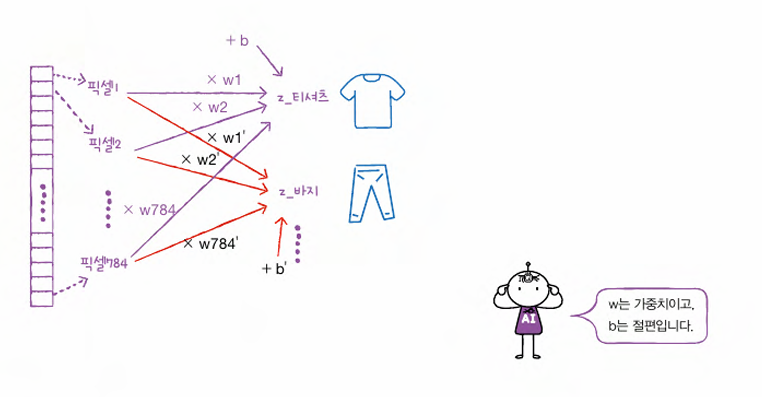

# 인공 신경망

- 가장 기본적인 인공 신경망은 확률적 경사 하강법을 사용하는 로지스틱 회귀와 같다?

- 패션 아이템 분류 문제를 인공 신경망으로 표현한 그림

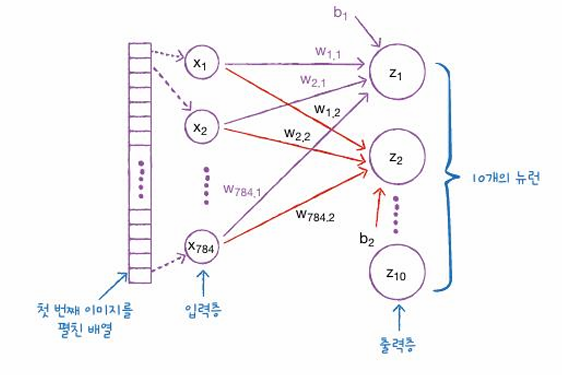

- 우리는 레이블이 10개 였으므로 클래스도 10개.
- 신경망의 최종 값 = 출력층 output layet
- 신경망에서 z값을 계산하는 단위 = 뉴런 (또는 유닛)
- 픽셀1, 픽셀2를 x1, x2와같이 바꿈. x1~x784를 입력층이라고 부름 (입력층은 픽셀값 그 자체이고 계산x)



---



---



---

딥러닝 라이브러리!
- 그래픽 처리 장치인 GPU 사용 (GPU는 벡터와 행렬 연산에 매우 최적화)
- Keras는 텐서플로의 고수준 API (GPU연산 수행하는 다른 라이브러리를 백엔드로 사용하는 방식 ㅇㅇ)


### 인공 신경망으로 모델 만들기

In [11]:
# 검증 세트 나누기
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

mnist 데이터셋은 이미 잘 섞인 데이터라 굳이 split 안하고 앞/뒤에서 10000개 정도 덜어서 검증 세트로 만들어도 되지만...

In [12]:
print(train_scaled. shape, train_target.shape)

(48000, 784) (48000,)


In [13]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)




> 밀집층 이란?

- 위의 그림에서 784개의 픽셀과 오른쪽에 있는 10개의 뉴런이 모두 연결된다면 784*10=7840개의 선이 생김
- 이것을 밀집층이라고 함 (또는 완전 연결층)



In [14]:
# keras의 dense 클래스를 사용해 밀집층 만들기

# dense = keras.layers.Dense(뉴런 개수, 뉴런 출력에 적용할 함수, 입력의 크기)

dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- 다중 분류 모델이므로 softmax 사용
- 이중 분류의 경우 (2개의 클래스 분류) sigmoid 함수 사용

In [15]:
# 밀집층을 가진 신경망 모델 만들기

model = keras.Sequential([dense])

# sequential 클래스의 객체를 만들 때 앞에서 만든 밀집층의 객체 dense 를 전달
# 여기서 만든 model 객체 = 신경망 모델

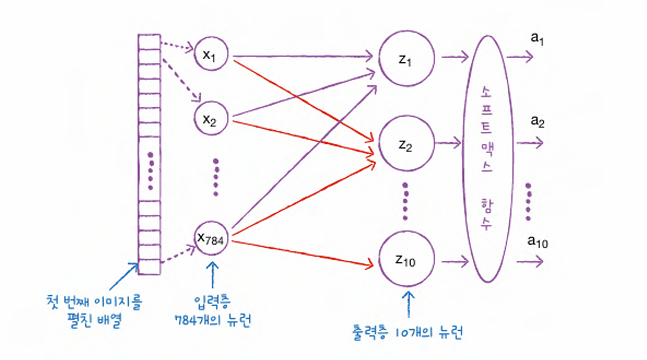

- **활성화 함수** = 소프트맥스와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수

# 인공 신경망으로 패션 아이템 분류하기

In [16]:
# 케라스 모델 훈련 전 model 객체의 compile 메서드에서 손실함수 지정하기

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 다중 분류라서 크로스 엔드로피 손실함수 사용 (이진 분류일때는 이진 엔트로피 손실함수)


💡 이 문장의 핵심 한 줄 요약:

**"예측한 확률이 실제 정답이랑 얼마나 다른지 계산하는 공식(=크로스 엔트로피)을 설명하고 있어요!"**

🍔 비유 먼저: 햄버거 맞히기 게임

당신은 친구가 먹고 있는 햄버거가 불고기인지 치킨인지 맞히는 게임을 하고 있어요.

확신이 들면 "불고기일 확률 90%"라고 말할 수 있고, 애매하면 "50% 불고기"라고도 말할 수 있어요.

그다음 친구가 진짜 뭘 먹고 있었는지(=정답)을 확인해요.

당신의 예측이 정답과 얼마나 가까운지 점수로 매겨야겠죠?

이 점수를 매기는 수학 공식이 바로 이 크로스 엔트로피 손실 함수예요.

🧠 본문 해석 (쉽게 풀기)
1. 출력값 a란?
모델이 예측한 확률값이에요.
예: a = 0.9이면 → "이건 정답일 확률이 90%야!" 라는 뜻이에요.

2. 정답이 1일 때 (= 진짜 양성 샘플일 때)
손실함수는: -log(a)

  - a가 0.9이면 → -log(0.9) = 작음 → 잘 맞췄다!

  - a가 0.1이면 → -log(0.1) = 큼 → 많이 틀렸다!

3. 정답이 0일 때 (= 진짜 음성 샘플일 때)
손실함수는: -log(1-a)

  - a가 0.1이면 → 1-a = 0.9 → -log(0.9) = 작음 → 잘 맞췄다!

  - a가 0.9이면 → 1-a = 0.1 → -log(0.1) = 큼 → 틀림!

🔄 그래서 두 가지 경우를 하나로 합치면?

`손실 = - (정답 × log(a) + (1-정답) × log(1-a))`

정답이 1이면: -log(a)

정답이 0이면: -log(1-a)

자동으로 골라서 계산됨! 이게 크로스 엔트로피 손실 함수예요.

0, 1, 2와 같이 정수로 된 타겟값(레이블 값)을 원핫인코딩으로 변환해야됨

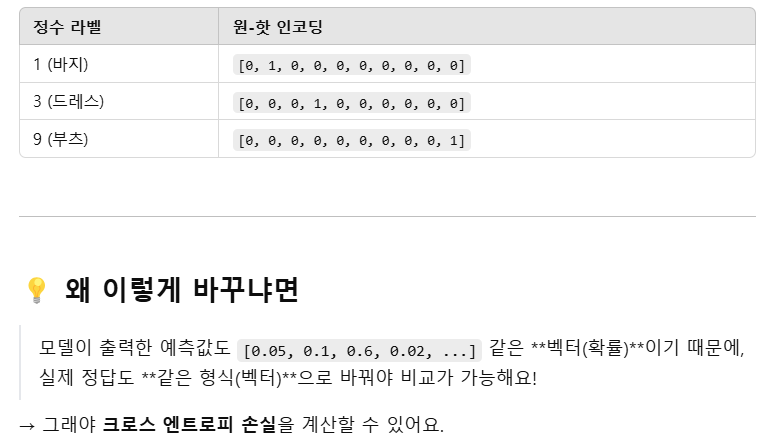

In [17]:
print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


- compile() 메서드의 metrics 매개변수
  - 케라스는 모델이 훈련할 때 에포크마다 손실 값을 출력해줌
  - 손실 값이 줄어들면 => 훈련이 잘되었네!
  - 정확도를 함께 출력하면 더 좋겠지?

In [18]:
# model 훈련

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7358 - loss: 0.7827
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8367 - loss: 0.4824
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8428 - loss: 0.4634
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8508 - loss: 0.4384
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8554 - loss: 0.4253


In [19]:
# 모델 평가

model.evaluate(val_scaled, val_target)

# accuray 83%정도

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8430 - loss: 0.4424


[0.44933345913887024, 0.8447499871253967]